In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


import pandas as pd
from sklearn.preprocessing import OneHotEncoder



# STEP 3: Oil Dataset
<hr/>

In [2]:
df_train = pd.read_csv('./Data/step2/df_train.csv')
df_test = pd.read_csv('./Data/step2/df_test.csv')
df_submission = pd.read_csv('./Data/step2/df_submission.csv')


df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_submission['date'] = pd.to_datetime(df_submission['date'])



In [3]:
oil = pd.read_csv('./Data/kaggle/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

### Feature Engineering and Analysis

In [5]:
oil['date'] = pd.to_datetime(oil['date'])

# Extract year and month from the date
oil['year'] = oil['date'].dt.year
oil['month'] = oil['date'].dt.month

#### Check Sasonality and Tendency of the oil price

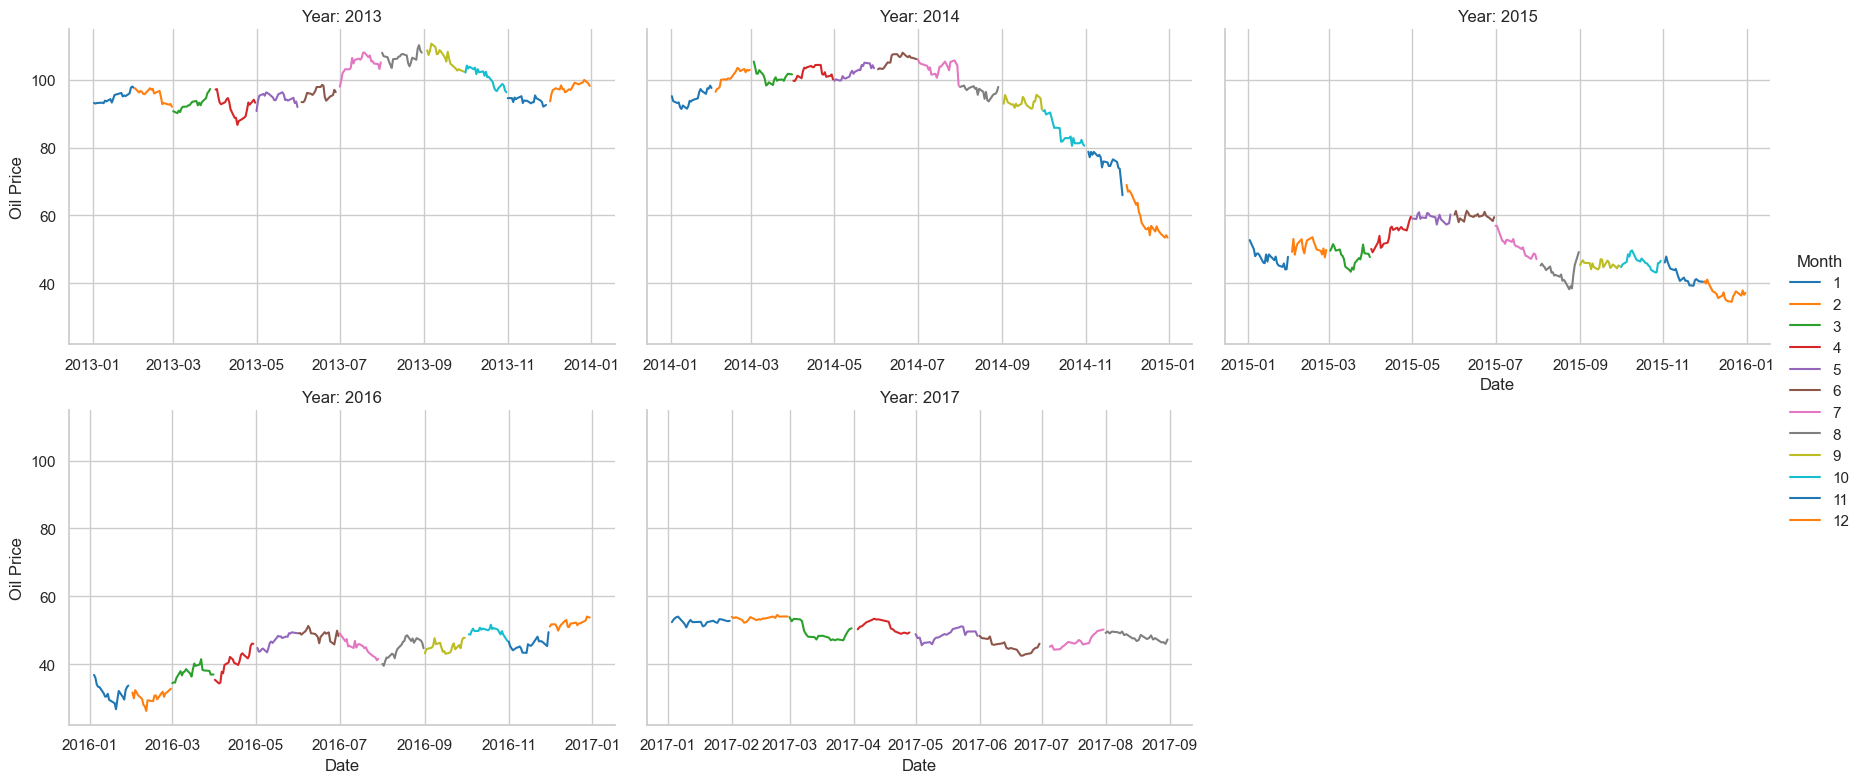

In [6]:
sns.set(style="whitegrid")

# Convert date column to datetime


oil_g = oil.dropna()

# Create a FacetGrid for each year
g = sns.FacetGrid(oil_g, col="year", col_wrap=3, height=4, aspect=1.5, sharex=False)
g.map_dataframe(sns.lineplot, x="date", y="dcoilwtico", hue="month", palette="tab10")

# Adjust the labels and titles
g.set_axis_labels("Date", "Oil Price")
g.set_titles(col_template="Year: {col_name}")
g.add_legend(title="Month")

plt.show()

- The seasonality of the price is not very clear. Some years the price rises in December and some years it falls.

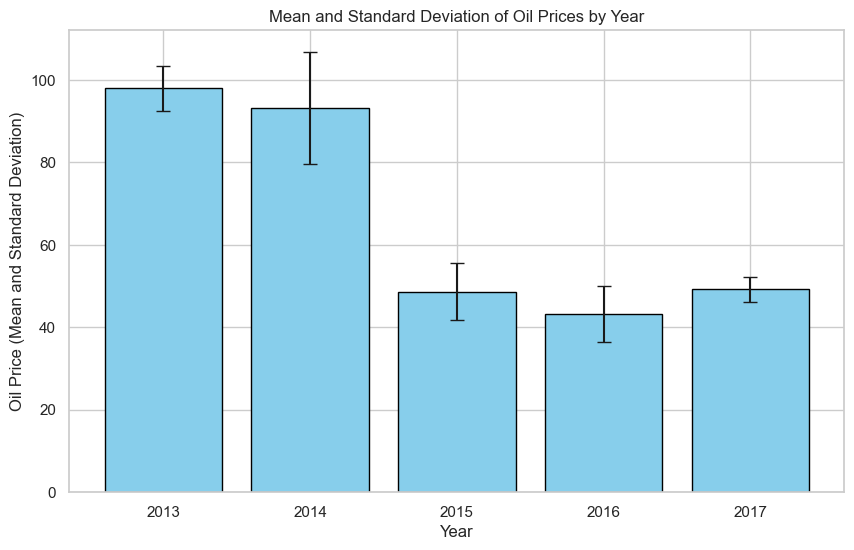

In [7]:
stats = oil_g.groupby('year')['dcoilwtico'].agg(['mean', 'std']).reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(stats['year'], stats['mean'], yerr=stats['std'], capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Oil Price (Mean and Standard Deviation)')
plt.title('Mean and Standard Deviation of Oil Prices by Year')
plt.xticks(stats['year'])

# Show the plot
plt.show()

- Starting in 2015 there has been a drop in prices, but the trend is unclear. At first glance, it looks like the average will remain the same in 2018.

#### Input missing values of oil price

In [8]:
# Generate a complete date range based on the minimum and maximum dates in the dataset
min_date = oil['date'].min()
max_date = oil['date'].max()
complete_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Identify missing dates
missing_dates = complete_date_range.difference(oil['date'])
len(missing_dates), oil['date'].nunique()


(486, 1218)

In [9]:
oil = pd.concat([pd.DataFrame({
    'date': missing_dates,
    'dcoilwtico': [np.nan]*len(missing_dates)
}), oil]).sort_values('date')

In [10]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

In [11]:
oil.isna().sum()

date            0
dcoilwtico      1
year          486
month         486
dtype: int64

- The missing values will be replaced with inerpoalation

In [12]:
oil.iloc[0:3]

,date,dcoilwtico,year,month
0,2013-01-01,NaN,2013.0,1.0
1,2013-01-02,93.14,2013.0,1.0
2,2013-01-03,92.97,2013.0,1.0


In [13]:
oil.iloc[260:263]

,date,dcoilwtico,year,month
186,2013-09-18,108.23,2013.0,9.0
187,2013-09-19,106.26,2013.0,9.0
188,2013-09-20,104.70,2013.0,9.0


In [14]:
oil.loc[
    (oil['date'].dt.month == 1) & 
    (oil['date'].dt.day == 1) & 
    (oil['date'].dt.year == 2013),
    'dcoilwtico'
] = 93.14

In [15]:
oil[(oil['date'].dt.month == 1) & (oil['date'].dt.day == 1)]

,date,dcoilwtico,year,month
0,2013-01-01,93.140,2013.0,1.0
261,2014-01-01,96.655,2014.0,1.0
522,2015-01-01,53.085,2015.0,1.0
783,2016-01-01,37.050,2016.0,1.0
417,2017-01-01,53.055,NaN,NaN


-   For the first day of the month in 2013 we'll repeat the value of the second day, since the variation wasn't big in 2014

### Encode and Generate Sets

In [16]:
df_train = df_train.merge(oil[['date', 'dcoilwtico']], how='left', on='date')
df_test = df_test.merge(oil[['date', 'dcoilwtico']], how='left', on='date')
df_submission = df_submission.merge(oil[['date', 'dcoilwtico']], how='left', on='date')

In [24]:
holiday_cols = ['is_National_holiday', 'day_after_national_holiday',
       'day_before_national_holiday', 'is_Local_holiday',
       'is_Regional_holiday', 'is_Local_holiday_real',
       'is_Regional_holiday_real']

In [26]:
X_train_1, y_train = df_train[['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico']], df_train['sales']
X_test_1, y_test = df_test[['store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico']], df_test['sales']
X_submission_1 = df_submission[['id', 'store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico']]

In [25]:
X_train_2, y_train = df_train[['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico'] + holiday_cols], df_train['sales']
X_test_2, y_test = df_test[['store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico'] + holiday_cols], df_test['sales']
X_submission_2 = df_submission[['id', 'store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store', 'dcoilwtico'] + holiday_cols]

In [27]:

def encode_one_how(X_train, X_test, X_submission, categorical_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train[categorical_cols])

    # Transform the training and test data
    train_encoded_array = encoder.transform(X_train[categorical_cols])
    test_encoded_array = encoder.transform(X_test[categorical_cols])
    submission_encoded_array = encoder.transform(X_submission[categorical_cols])
    

    # Create DataFrames with the encoded data
    train_encoded_df = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    test_encoded_df = pd.DataFrame(test_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    submission_encoded_df = pd.DataFrame(submission_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_submission.index)
    

    # Concatenate the original DataFrame (excluding the original categorical columns) with the encoded DataFrame
    X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols), train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols), test_encoded_df], axis=1)
    X_submission_encoded = pd.concat([X_submission.drop(columns=categorical_cols), submission_encoded_df], axis=1)
    
    return X_train_encoded, X_test_encoded, X_submission_encoded
        

In [28]:
X_train_1, X_test_1, X_submission_1 = encode_one_how(X_train_1, X_test_1, X_submission_1, ['family', 'month', 'day_of_week'])

In [29]:
X_train_2, X_test_2, X_submission_2 = encode_one_how(X_train_2, X_test_2, X_submission_2, ['family', 'month', 'day_of_week'])


In [31]:
X_train_1.shape, X_test_1.shape, X_submission_1.shape

((2603502, 58), (404514, 58), (28512, 59))

In [32]:
X_train_1.columns

Index(['store_nbr', 'onpromotion', 'year', 'in_store_list', 'day_off_store',
       'dcoilwtico', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'mont

In [30]:
X_train_2.shape, X_test_2.shape, X_submission_2.shape

((2603502, 65), (404514, 65), (28512, 66))

In [33]:
X_train_2.columns

Index(['store_nbr', 'onpromotion', 'year', 'in_store_list', 'day_off_store',
       'dcoilwtico', 'is_National_holiday', 'day_after_national_holiday',
       'day_before_national_holiday', 'is_Local_holiday',
       'is_Regional_holiday', 'is_Local_holiday_real',
       'is_Regional_holiday_real', 'family_AUTOMOTIVE', 'family_BABY CARE',
       'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PRE

### Models Evaluation

In [34]:
# Train and evaluate model for each store
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)



#### Compare Models and Training Sets - One Store Prediction

In [35]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

sets = {
    'Train With Oil Prince': [
        X_train_1[X_train_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_1['store_nbr'] == 10], 
        X_test_1[X_test_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_1['store_nbr'] == 10]
    ],
    'Train With Oil Prince and Holiday Info': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
    
}
def evaluate_models(models, sets):
    results = []

    for set_name, data in sets.items():
        X_train, y_train, X_test, y_test = data
        
        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred[y_pred < 0] = 0
            # Calculate Mean Squared Error
            score = rmsle(y_test, y_pred)
            
            # Append results
            results.append({
                'Set': set_name,
                'Model': model_name,
                'RMSLE': score
            })
    return pd.DataFrame(results)

In [36]:
results = evaluate_models(models, sets)
results

,Set,Model,RMSLE
0,Train With Oil Prince,RandomForest,0.573412
1,Train With Oil Prince,XGBoost,1.681070
2,Train With Oil Prince and Holiday Info,RandomForest,0.575190
3,Train With Oil Prince and Holiday Info,XGBoost,1.681069


In [38]:
results.to_csv('./Data/step3/results.csv')

- Results got worst with addition of oil price, when compared to step1 results

#### Train for all Stores 

In [42]:


def train_per_store(stores, X_train, y_train, X_test, y_test):
    all_y_true = []
    all_y_pred_rf = []
    models = {}

    for store_nbr in stores:
        print('Store', store_nbr)
        X_train_st = X_train[X_train['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        X_test_st = X_test[X_test['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        
        y_train_st = y_train[X_train['store_nbr'] == store_nbr]
        y_test_st = y_test[X_test['store_nbr'] == store_nbr]
        
        # Train Random Forest Regressor
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_rf = rf.predict(X_test_st)
        # Append true values and predictions to the lists
        all_y_true.extend(y_test_st)
        all_y_pred_rf.extend(y_pred_rf)
        
        
        models[store_nbr] = {
            'rf': rf
        }
    
    total_rmsle_rf = rmsle(np.array(all_y_true), np.array(all_y_pred_rf))

    return {
        'Random Forest': total_rmsle_rf,
        'models': models
    }
        
def predict_per_store(models, X_submission, model_name='rf'):
    stores = X_submission['store_nbr'].unique()
    predictions = {'id': [], 'sales': []}
    for store in stores:
        X_submission_st = X_submission[X_submission['store_nbr'] == store]
        ids = X_submission_st['id']
        X_submission_st = X_submission_st.drop(columns=['id', 'store_nbr'])
        y_pred = models[store][model_name].predict(X_submission_st)

        predictions['id'] += list(ids)
        predictions['sales'] += list(y_pred)
        
    predictions_df = pd.DataFrame(predictions)
    return predictions_df
        


In [43]:
stores = df_train['store_nbr'].unique()
result = train_per_store(stores, X_train_1, y_train, X_test_1, y_test)
print('RMLSE with One hot', result['Random Forest'])

Store 1
Store 10
Store 11
Store 12
Store 13
Store 14
Store 15
Store 16
Store 17
Store 18
Store 19
Store 2
Store 20
Store 21
Store 22
Store 23
Store 24
Store 25
Store 26
Store 27
Store 28
Store 29
Store 3
Store 30
Store 31
Store 32
Store 33
Store 34
Store 35
Store 36
Store 37
Store 38
Store 39
Store 4
Store 40
Store 41
Store 42
Store 43
Store 44
Store 45
Store 46
Store 47
Store 48
Store 49
Store 5
Store 50
Store 51
Store 52
Store 53
Store 54
Store 6
Store 7
Store 8
Store 9
RMLSE with One hot 0.7515214487220195


In [46]:
third_submission_df = predict_per_store(result['models'], X_submission_1)
third_submission_df.to_csv('./Data/submssions/submission_step3.csv', index=False)

## Save datasets

In [40]:
df_train.to_csv('./Data/step3/df_train.csv', index=False)
df_test.to_csv('./Data/step3/df_test.csv', index=False)
df_submission.to_csv('./Data/step3/df_submission.csv', index=False)